In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from tqdm import tqdm
import glob
import sys

ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)
import h3
import geopandas as gpd
import shapely

# Check Vitality Changes across the year groups

In [2]:

ROOTFOLDER = "/lustre1/g/geog_pyloo/05_timemachine"
PANO_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_pano.csv"
PATH_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/gsv_path.csv"
CURATED_FOLDER = f"{ROOTFOLDER}/_curated"
META_PATH = "{ROOTFOLDER}/GSV/gsv_rgb/{cityabbr}/gsvmeta/{cityabbr}_meta.csv"
EXFOLDER = os.path.join(CURATED_FOLDER, "c_object_crossectional")
EXFOLDER_LONG = os.path.join(CURATED_FOLDER, "c_object_longitudinal")
EXFOLDER_SEG_LONG = os.path.join(CURATED_FOLDER, "c_seg_longitudinal_all")
if not os.path.exists(EXFOLDER):
    os.makedirs(EXFOLDER)
if not os.path.exists(EXFOLDER_LONG):
    os.makedirs(EXFOLDER_LONG)
year_group = ["2015-2018", "2020-2023"]

segfiles = glob.glob(f"{EXFOLDER_SEG_LONG}/*.parquet")
# objfiles = glob.glob("{CURATED_FOLDER}/{city_abbr}/*_objects.parquet")
OBJECT_SOURCE_FOLDER = "{CURATED_FOLDER}/{city_abbr}/*_objects.parquet"

# variables may change later
res = 9

min_num_pano = 2 # minimum number of panoid per each hexagon to avoid sampling bias
year_to_exclude = 2019 # don't use this since we want to measure the change

In [3]:
## 1. Data Preprocessing Steps
# set up one city to test
city = "Seoul"

city_abbr = city.lower().replace(" ", "")
objfiles = glob.glob(OBJECT_SOURCE_FOLDER.format(CURATED_FOLDER=CURATED_FOLDER, city_abbr=city_abbr))
# read all object files and concat them into one df

# df_pano = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
# df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
df = pd.concat([pd.read_parquet(f) for f in objfiles])

In [5]:
df.shape

(4218152, 7)

In [12]:
df_path_sel = df_path[df_path['path'].str.contains("wg61GguhDldInl4uzO-8WQ_270.jpg")].reset_index(drop = True)
df_path_sel['path'].values[0]

'/lustre1/g/geog_pyloo/05_timemachine/GSV/gsv_rgb/milan/img_rgb/0_1/4/b/wg61GguhDldInl4uzO-8WQ_270.jpg'

In [6]:
## 1. Data Preprocessing Steps
# set up one city to test
city = "Seoul"

city_abbr = city.lower().replace(" ", "")
objfiles = glob.glob(OBJECT_SOURCE_FOLDER.format(CURATED_FOLDER=CURATED_FOLDER, city_abbr=city_abbr))
# read all object files and concat them into one df

df_pano = pd.read_csv(PANO_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
df_path = pd.read_csv(PATH_PATH.format(ROOTFOLDER=ROOTFOLDER, cityabbr=city_abbr))
# process the prediction results
df = pd.concat([pd.read_parquet(f) for f in objfiles])
df['panoid'] = df['img'].apply(lambda x: x[:22])

# only keep the panoid that has a path
df_pano_inner = df_pano[df_pano['panoid'].isin(df_path['panoid'].unique())].reset_index(drop = True)
print(df_pano_inner.shape[0], "out of ", df_pano.shape[0], "panoids have path")
df_pano_inner['hex_id'] = df_pano_inner.apply(lambda x: h3.geo_to_h3(x['lat'], x['lon'], res), axis=1)

# keep these hex
df_all_keep = df_pano_inner[(df_pano_inner['year']!=year_to_exclude)&(df_pano_inner['year']>=2015)].reset_index(drop = True)
print(df_all_keep.shape[0], "panoids are kept")
df_all_keep['year_group'] = df_all_keep['year'].apply(lambda x: year_group[0] if x < 2019 else year_group[1])

# get number of panoid per hex
df_all_keep_hex = df_all_keep.groupby(['hex_id','year_group'])['panoid'].nunique().reset_index(name='panoid_n')
df_all_keep_hex = df_all_keep_hex[df_all_keep_hex['panoid_n']>=min_num_pano]\
    .groupby('hex_id').filter(lambda x: len(x) == 2).reset_index(drop = True)
df_all_keep_hex['geometry'] = df_all_keep_hex['hex_id'].apply(lambda x: shapely.geometry.Polygon(h3.h3_to_geo_boundary(x, geo_json = True)))
df_all_keep_hex = gpd.GeoDataFrame(df_all_keep_hex, crs="EPSG:4326")

279036 out of  756601 panoids have path
211350 panoids are kept


In [12]:
df_all_keep_hex = df_all_keep.groupby(['hex_id','year_group'])['panoid'].nunique().reset_index(name='panoid_n')
df_all_keep_hex.head()

,hex_id,year_group,panoid_n
0,8930e034483ffff,2015-2018,20
1,8930e034493ffff,2015-2018,6
2,8930e03449bffff,2015-2018,27
3,8930e0344a3ffff,2015-2018,3
4,8930e0344b3ffff,2015-2018,30


In [20]:
df_all_keep_hex[df_all_keep_hex['panoid_n']>=min_num_pano].groupby('hex_id').size().value_counts()

1    6389
2       3
Name: count, dtype: int64

In [18]:
df_all_keep_hex.sort_values('panoid_n', ascending = True).head(100)

,hex_id,year_group,panoid_n
3739,8930e1cb063ffff,2015-2018,1
4424,8930e1d18b7ffff,2015-2018,1
3698,8930e1cae2fffff,2015-2018,1
75,8930e03617bffff,2015-2018,1
5217,8930e1d9133ffff,2015-2018,1
...,...,...,...
2940,8930e1c8833ffff,2015-2018,2
1860,8930e1c1acbffff,2015-2018,2
1077,8930e0aec6fffff,2015-2018,2
4403,8930e1d144bffff,2015-2018,2


In [7]:
# object specific processing
variable_ls_kep = ['person','car','truck','bus','bicycle','motorcycle',
                   'train','fire hydrant','bench','chair','table', "traffic light", 'stop sign']
df_sel = df[df['object_name'].isin(variable_ls_kep)].groupby(['panoid','object_name']).size().reset_index(name='n')
# count all observed objects across all panoids
object_summary = df_all_keep[['panoid','year_group','hex_id']].merge(df_sel, 
                              on = 'panoid', how = 'left')\
    .groupby(['hex_id','year_group','object_name'])['n'].sum().reset_index()\
        .merge(df_all_keep_hex[['hex_id','panoid_n','year_group']], 
               on = ['hex_id','year_group'], 
               how = 'right').fillna(0)
object_summary['n_per_pano'] = object_summary['n']/object_summary['panoid_n']
object_summary.head()

,hex_id,year_group,object_name,n,panoid_n,n_per_pano
0,8930e1d9dabffff,2015-2018,bench,3.0,26,0.115385
1,8930e1d9dabffff,2015-2018,bicycle,2.0,26,0.076923
2,8930e1d9dabffff,2015-2018,bus,11.0,26,0.423077
3,8930e1d9dabffff,2015-2018,car,268.0,26,10.307692
4,8930e1d9dabffff,2015-2018,motorcycle,19.0,26,0.730769


In [197]:
object_summary.to_csv(f"{EXFOLDER_LONG}/c_object_{city_abbr}.csv", index = False)
# export the complete hexagon id for comparison (this is the full sample to use)
df_all_keep_hex[['hex_id', 'year_group']].to_csv(f"{EXFOLDER_LONG}/c_hex_{city_abbr}.csv", index = False)

# Code below are for viz only. No need to process

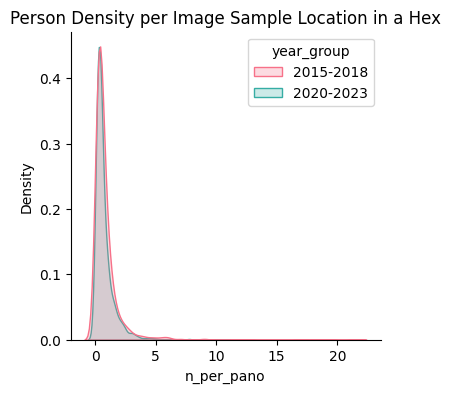

In [198]:
# object_summary[object_summary['object_name']=='person']['n_per_pano'].hist(density = True, bins = 50)
viz_variable = 'person'
import seaborn as sns
fig, ax = plt.subplots(figsize=(4, 4))
sns.kdeplot(
    data = object_summary[object_summary['object_name']==viz_variable], 
    hue = 'year_group',
    x = 'n_per_pano',
    fill = True,
    palette = sns.color_palette("husl", n_colors=2)
            )
plt.title(f"{viz_variable.title()} Density per Image Sample Location in a Hex")
sns.despine()

/tmp/ipykernel_2875985/1147662655.py:4: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  .plot(column='n_per_pano', legend=True, figsize = (8, 8),


(-71.65303835666674, -70.60943725440396, 41.9191685712874, 42.807407268961626)

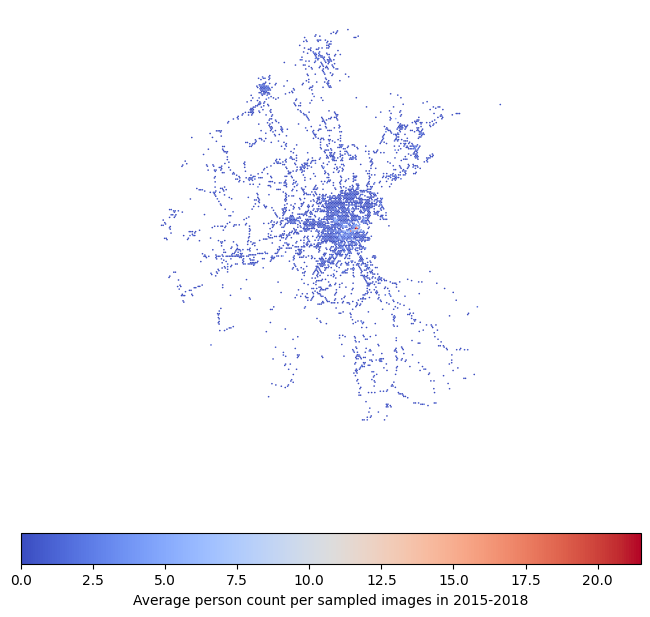

In [199]:
df_hex_keep = df_all_keep_hex.merge(object_summary[object_summary['object_name']==viz_variable], 
                                    on = ['hex_id','year_group'], how = 'left').fillna(0)
df_hex_keep[df_hex_keep['year_group']==year_group[0]]\
    .plot(column='n_per_pano', legend=True, figsize = (8, 8),
    legend_kwds={'label': f"Average {viz_variable} count per sampled images in {year_group[0]}", 
    'orientation': "horizontal"},colormap='coolwarm')
# remove the axis
plt.axis('off')

/tmp/ipykernel_2875985/1224014617.py:2: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  .plot(column='n_per_pano', legend=True, figsize = (8, 8),


(-71.65303835666674, -70.60943725440396, 41.9191685712874, 42.807407268961626)

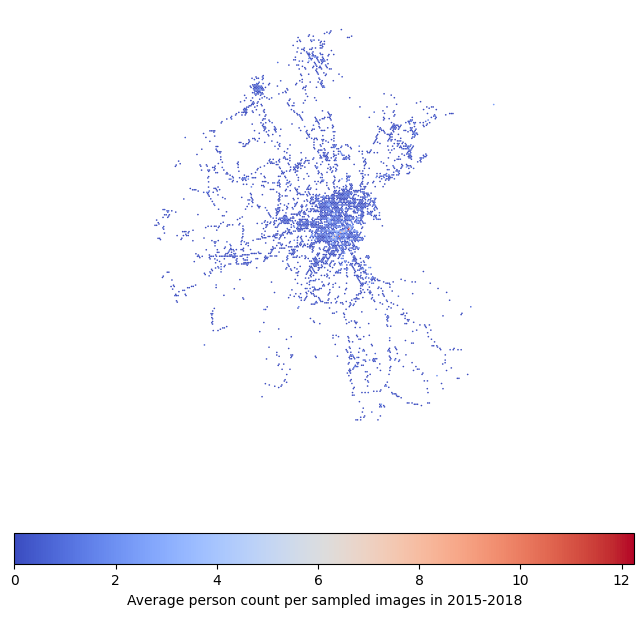

In [200]:
df_hex_keep[df_hex_keep['year_group']==year_group[1]]\
    .plot(column='n_per_pano', legend=True, figsize = (8, 8),
    legend_kwds={'label': f"Average {viz_variable} count per sampled images in {year_group[0]}", 
    'orientation': "horizontal"},colormap='coolwarm')
# remove the axis
plt.axis('off')

/tmp/ipykernel_2875985/3085870728.py:8: FutureWarning: 'colormap' is deprecated, please use 'cmap' instead (for consistency with matplotlib)
  df_hex_keep[df_hex_keep['year_group']==year_group[0]].plot(column=f'log_delta_{viz_variable}', legend=True, figsize = (8, 8),


(-122.52420512344989,
 -122.33984807191169,
 37.69928289567844,
 37.839480304517224)

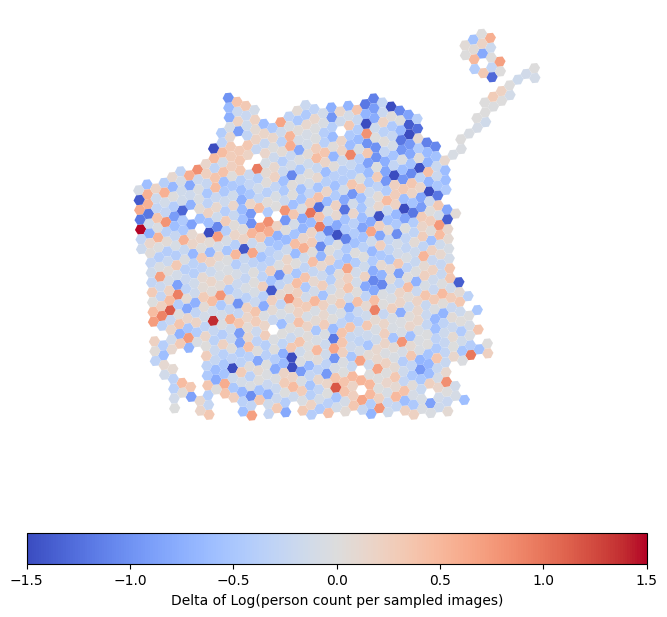

In [194]:
# plot the delta between two year groups
df_hex_keep = df_hex_keep.sort_values(['hex_id', 'year_group']).reset_index(drop = True)
# calculate difference of the log transformed value
df_hex_keep[f'log_delta_{viz_variable}'] = \
    df_hex_keep.groupby('hex_id')['n_per_pano'].transform(lambda x: np.log(x+1).diff().iloc[-1])

# df_hex_keep['delta'] = df_hex_keep.groupby('hex_id')[f'{variable}_n'].transform(lambda x: x.diff().iloc[-1])
df_hex_keep[df_hex_keep['year_group']==year_group[0]].plot(column=f'log_delta_{viz_variable}', legend=True, figsize = (8, 8),
                                                              legend_kwds={'label': f"Delta of Log({viz_variable} count per sampled images)", 
                                                                            'orientation': "horizontal"},
                                                              colormap='coolwarm',
                                                              # center the colorbar to 0
                                                                vmin=-1.5, vmax=1.5)

plt.axis('off')

In [186]:
df_hex_keep.head()

,hex_id,year_group,panoid_n_x,geometry,object_name,n,panoid_n_y,n_per_pano,log_delta_person
0,892a100002fffff,2015-2018,6,"POLYGON ((-73.78162 40.84960, -73.78373 40.848...",0,0.0,0.0,0.000000,0.154151
1,892a100002fffff,2020-2023,6,"POLYGON ((-73.78162 40.84960, -73.78373 40.848...",person,1.0,6.0,0.166667,0.154151
2,892a1000047ffff,2015-2018,9,"POLYGON ((-73.79056 40.85996, -73.79267 40.859...",person,3.0,9.0,0.333333,-0.087011
3,892a1000047ffff,2020-2023,9,"POLYGON ((-73.79056 40.85996, -73.79267 40.859...",person,2.0,9.0,0.222222,-0.087011
4,892a100004fffff,2015-2018,8,"POLYGON ((-73.79485 40.85985, -73.79696 40.858...",0,0.0,0.0,0.000000,0.223144


In [187]:
df_hex_keep.drop('geometry', axis =1).to_csv(
    os.path.join(EXFOLDER_LONG, f"{city_abbr}_{viz_variable}.csv"), index=False)


In [ ]:
# do this later
drop_cateogry = ['boat','cat','baseball glove', 'orange', 'banana', 'teddy bear', 'cake',]

In [ ]:
df_pano_merge = df.groupby(['panoid','object_name']).count().reset_index()

In [91]:
city = "Singapore"
res = 9
variable = "person"
city_abbr = city.lower().replace(" ", "")
selfile = [x for x in longfiles if city_abbr in x][0]
segfile = [x for x in segfiles if city_abbr in x][0]

testdf = pd.read_parquet(os.path.join(EXFOLDER, selfile))
testdf = testdf[testdf["res"]==res].reset_index(drop = True)
segdf = pd.read_parquet(os.path.join(EXFOLDER_SEG_LONG, segfile))
segdf = segdf[segdf["res"]==res].reset_index(drop = True)

testdf.head()

cat,hex_id,year_group,street_furniture,car,person,bike,res
0,896520c0e03ffff,2015-2018,0.180000,1.080000,0.000000,0.080000,9
1,896520c0e03ffff,2020-2023,0.200000,1.186667,0.093333,0.013333,9
2,896520c0e0bffff,2015-2018,0.050000,0.950000,0.150000,0.050000,9
3,896520c0e0bffff,2020-2023,0.047619,0.976190,0.047619,0.000000,9
4,896520c0e0fffff,2015-2018,0.062500,0.875000,0.250000,0.125000,9


In [92]:
# make sure only compare the locations with (at least {threshold}) images available in both year_group 
img_count_threshold = 2
seg_df_valid = segdf[segdf['img_count']>=img_count_threshold].groupby("hex_id").filter(lambda x: len(x) == 2)
hex_valid = seg_df_valid[["hex_id","year_group","img_count","res"]].drop_duplicates()
print(segdf.shape[0], seg_df_valid.shape[0])

7398 7026


<Axes: >

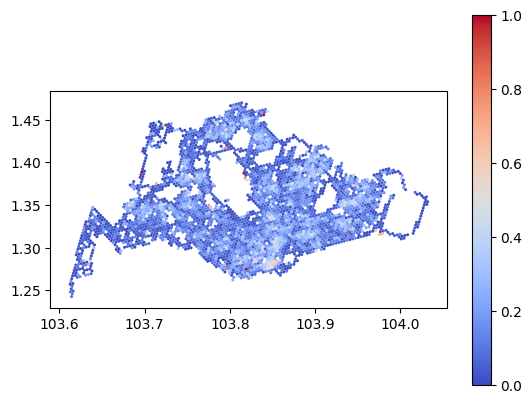

In [93]:
# construct h3 geometry and plot the person

pano_valid_df = hex_valid.merge(testdf, on = ["hex_id",'year_group',"res"], how = "left").fillna(0)
pano_valid_df["geometry"] = pano_valid_df["hex_id"]\
    .apply(lambda x: shapely.geometry.Polygon(h3.h3_to_geo_boundary(x, geo_json = True)))
gdf = gpd.GeoDataFrame(pano_valid_df, geometry = "geometry", crs = "EPSG:4326")
gdf[gdf['year_group']=='2020-2023'].plot(column = variable, legend = True, cmap = 'coolwarm')


<Axes: >

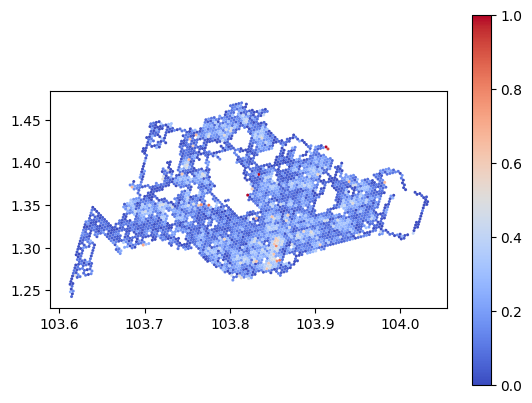

In [94]:
gdf[gdf['year_group']=='2015-2018'].plot(column = variable, legend = True, cmap = 'coolwarm')

In [86]:
# pivot the table and get delta between 2015-2018 and 2020-2023
# variable = "car"
pivot_df = gdf.pivot(index = "hex_id", columns = "year_group", values = variable).reset_index()
pivot_df[f'{variable}_delta'] = pivot_df['2020-2023'] - pivot_df['2015-2018']

<Axes: >

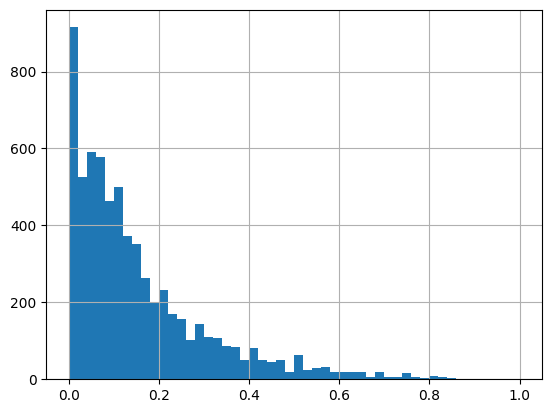

In [87]:
pivot_df['2020-2023'].hist(bins = 50)

<Axes: >

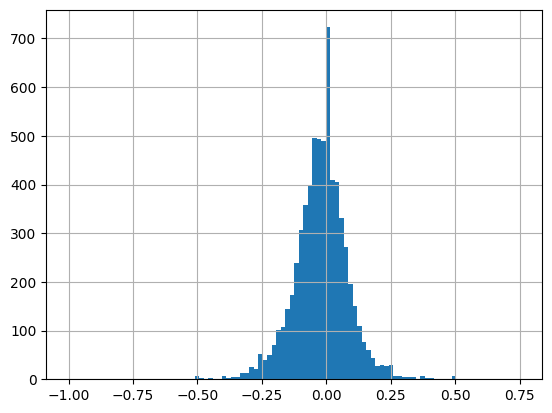

In [88]:
pivot_df[f'{variable}_delta'].hist(bins = 100)

In [89]:
pivot_gdf = gdf[['hex_id','geometry']].drop_duplicates('hex_id')\
    .merge(pivot_df[["hex_id",f'{variable}_delta']], on = "hex_id", how = "left")
pivot_gdf

,hex_id,geometry,person_delta
0,892a100002bffff,"POLYGON ((-73.78386 40.85219, -73.78597 40.851...",0.000000
1,892a100002fffff,"POLYGON ((-73.78162 40.84960, -73.78373 40.848...",0.125000
2,892a1000047ffff,"POLYGON ((-73.79056 40.85996, -73.79267 40.859...",-0.250000
3,892a1000063ffff,"POLYGON ((-73.79038 40.85467, -73.79249 40.853...",0.041721
4,892a1000067ffff,"POLYGON ((-73.78814 40.85208, -73.79025 40.851...",-0.108519
...,...,...,...
6559,892a10776c3ffff,"POLYGON ((-74.01706 40.67684, -74.01916 40.675...",0.042626
6560,892a10776c7ffff,"POLYGON ((-74.01482 40.67426, -74.01692 40.673...",0.115385
6561,892a10776d3ffff,"POLYGON ((-74.01503 40.67954, -74.01713 40.678...",0.209615
6562,892a10776d7ffff,"POLYGON ((-74.01279 40.67696, -74.01489 40.676...",-0.032051


<Axes: >

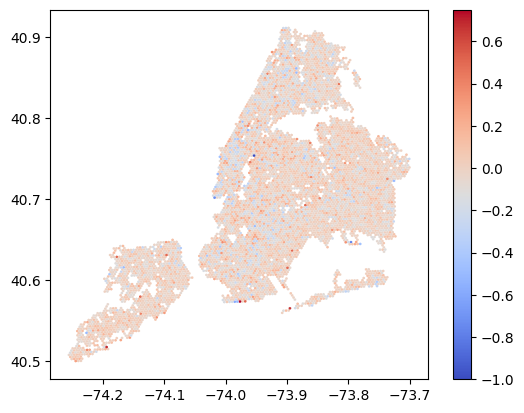

In [90]:
pivot_gdf.plot(column = f'{variable}_delta', legend = True, cmap = 'coolwarm')